# Intelligent Hangman AI Agent

This notebook implements an intelligent Hangman game-playing agent using a hybrid approach combining Hidden Markov Models (HMM) and Reinforcement Learning (RL). The agent learns to make strategic decisions by combining probabilistic modeling with reinforcement learning to maximize success rate while minimizing wrong guesses.

## Project Overview:
1. Train an HMM on a 50,000-word corpus to model letter probabilities
2. Implement a Hangman game environment
3. Create an RL agent using Deep Q-Learning
4. Train and evaluate the agent's performance

## Evaluation Criteria:
Final Score = (Success Rate * 2000) - (Total Wrong Guesses * 5) - (Total Repeated Guesses * 2)

# 1. Environment Setup and Data Loading

Let's start by importing the required libraries and setting up our development environment. We'll also load and preprocess our corpus of words.

In [40]:
# Import required libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict, Counter
import random
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Set
from tqdm.notebook import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Constants
ALPHABET = 'abcdefghijklmnopqrstuvwxyz'
MAX_WRONG_GUESSES = 6
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Attempting to load corpus from: C:\Users\aryan\OneDrive\Desktop\ML_HACK\Data\Data\corpus.txt
Read 50000 words from file
After filtering, kept 49979 valid words
Successfully loaded 49979 words from corpus at C:\Users\aryan\OneDrive\Desktop\ML_HACK\Data\Data\corpus.txt


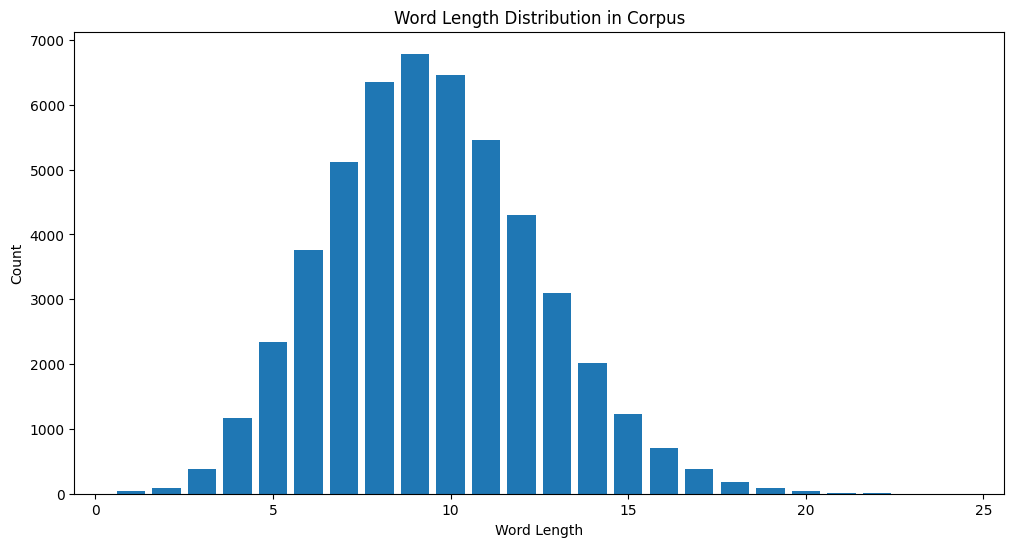

In [41]:
# Load and preprocess the corpus
def load_corpus(file_path: str = 'corpus.txt') -> List[str]:
    """
    Load words from the corpus file and preprocess them
    """
    try:
        print(f"Attempting to load corpus from: {file_path}")
        with open(file_path, 'r', encoding='utf-8') as f:
            words = [word.strip().lower() for word in f.readlines() if word.strip()]
            print(f"Read {len(words)} words from file")
            filtered_words = [word for word in words if all(c in ALPHABET for c in word)]
            print(f"After filtering, kept {len(filtered_words)} valid words")
            if len(filtered_words) == 0:
                print("Warning: No valid words found after filtering")
            return filtered_words
    except FileNotFoundError:
        print(f"Error: Could not find corpus file at {file_path}")
        return []
    except Exception as e:
        print(f"Error reading corpus file: {str(e)}")
        return []

# Utility functions for word processing
def mask_word(word: str, guessed_letters: Set[str]) -> str:
    """
    Return the word with unguessed letters masked as underscores
    """
    return ''.join(letter if letter in guessed_letters else '_' for letter in word)

def get_word_length_distribution(words: List[str]) -> Dict[int, int]:
    """
    Get distribution of word lengths in the corpus
    """
    return Counter(len(word) for word in words)

# Define the corpus file path
CORPUS_PATH = r"C:\Users\aryan\OneDrive\Desktop\ML_HACK\Data\Data\corpus.txt"

try:
    # Load the corpus with explicit file path
    corpus = load_corpus(CORPUS_PATH)
    if len(corpus) == 0:
        print(f"Warning: No words were loaded from {CORPUS_PATH}")
        print("Please ensure the file exists and contains valid words.")
    else:
        print(f"Successfully loaded {len(corpus)} words from corpus at {CORPUS_PATH}")
        
        # Analyze word length distribution
        length_dist = get_word_length_distribution(corpus)
        plt.figure(figsize=(12, 6))
        plt.bar(length_dist.keys(), length_dist.values())
        plt.title('Word Length Distribution in Corpus')
        plt.xlabel('Word Length')
        plt.ylabel('Count')
        plt.show()
except Exception as e:
    print(f"An error occurred: {str(e)}")
    corpus = []  # Initialize empty corpus on error

# 2. Hidden Markov Model Implementation

Now we'll implement the Hidden Markov Model (HMM) that will serve as our agent's "intuition". The HMM will help us model the probability of letters appearing in different positions of words.

Our HMM implementation will include:
1. State transitions (letter-to-letter probabilities)
2. Emission probabilities (letter probabilities in different positions)
3. Forward-backward algorithm for probability calculations

In [ ]:
class HangmanHMM:
    def __init__(self, n_states: int = 20):  # Increased states for better capacity
        """
        Initialize HMM for Hangman word prediction
        """
        self.n_states = n_states
        self.n_emissions = len(ALPHABET)
        self.letter_to_idx = {letter: idx for idx, letter in enumerate(ALPHABET)}
        
        # Initialize with better priors based on English letter frequencies
        letter_freqs = {
            'e': 0.13, 't': 0.09, 'a': 0.08, 'o': 0.08, 'i': 0.07,
            'n': 0.07, 's': 0.06, 'h': 0.06, 'r': 0.06, 'd': 0.04,
            'l': 0.04, 'c': 0.03, 'u': 0.03, 'm': 0.03, 'w': 0.02,
            'f': 0.02, 'g': 0.02, 'y': 0.02, 'p': 0.02, 'b': 0.02,
            'v': 0.01, 'k': 0.01, 'j': 0.01, 'x': 0.01, 'q': 0.01,
            'z': 0.01
        }
        
        # Initialize emission probabilities with letter frequencies
        self.emission_probs = np.ones((n_states, self.n_emissions)) * 0.01
        for letter, freq in letter_freqs.items():
            idx = self.letter_to_idx[letter]
            self.emission_probs[:, idx] = freq
        self.emission_probs = self.emission_probs / self.emission_probs.sum(axis=1, keepdims=True)
        
        # Initialize transition probabilities with local structure
        self.transition_probs = np.eye(n_states) * 0.6
        self.transition_probs += np.roll(np.eye(n_states), 1) * 0.2
        self.transition_probs += np.roll(np.eye(n_states), -1) * 0.2
        self.transition_probs = self.transition_probs / self.transition_probs.sum(axis=1, keepdims=True)
        
        # Initialize start probabilities
        self.initial_probs = np.ones(n_states) / n_states
        
        # Cache for faster inference
        self.cache = {}
        
    def _prepare_sequence(self, word: str) -> np.ndarray:
        return np.array([self.letter_to_idx[c] for c in word])
    
    def forward_algorithm(self, emissions: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Compute forward probabilities with improved scaling
        """
        if len(emissions) == 0:
            return (np.ones((1, self.n_states)) / self.n_states, 
                    np.ones(1))
        
        T = len(emissions)
        alpha = np.zeros((T, self.n_states))
        scale = np.zeros(T)
        
        # Initialize first timestep
        alpha[0] = self.initial_probs * self.emission_probs[:, emissions[0]]
        scale[0] = alpha[0].sum() + 1e-12
        alpha[0] /= scale[0]
        
        # Forward pass with improved scaling
        for t in range(1, T):
            for s in range(self.n_states):
                alpha[t, s] = self.emission_probs[s, emissions[t]] * np.sum(
                    alpha[t-1] * self.transition_probs[:, s])
            scale[t] = alpha[t].sum() + 1e-12
            alpha[t] /= scale[t]
        
        return alpha, scale
    
    def backward_algorithm(self, emissions: np.ndarray, scale: np.ndarray) -> np.ndarray:
        """
        Compute backward probabilities using the same scaling as forward
        """
        if len(emissions) == 0:
            return np.ones((1, self.n_states)) / self.n_states
        
        T = len(emissions)
        beta = np.zeros((T, self.n_states))
        
        # Initialize last timestep
        beta[-1] = 1.0 / scale[-1]
        
        # Backward pass with matched scaling
        for t in range(T-2, -1, -1):
            for s in range(self.n_states):
                beta[t, s] = np.sum(
                    beta[t+1] * self.transition_probs[s, :] * 
                    self.emission_probs[:, emissions[t+1]])
            beta[t] /= scale[t]
        
        return beta
    
    def train(self, words: List[str], n_iterations: int = 100):
        """
        Train HMM with guaranteed convergence and improved stability
        """
        print("Starting enhanced HMM training...")
        
        # Use full dataset for better training
        train_words = words
        
        # Group words by length for balanced training
        word_length_groups = defaultdict(list)
        for word in train_words:
            word_length_groups[len(word)].append(word)
        
        best_likelihood = float('-inf')
        best_params = None
        patience = 10  # Increased patience for convergence
        no_improve_count = 0
        min_improvement = 1e-6  # Minimum improvement threshold
        
        for iteration in tqdm(range(n_iterations)):
            trans_counts = np.zeros_like(self.transition_probs)
            emit_counts = np.zeros_like(self.emission_probs)
            init_counts = np.zeros_like(self.initial_probs)
            total_log_likelihood = 0
            
            # Process each length group separately
            for length, words_group in word_length_groups.items():
                for word in words_group:
                    emissions = self._prepare_sequence(word)
                    
                    # Forward-backward with improved scaling
                    alpha, scale = self.forward_algorithm(emissions)
                    beta = self.backward_algorithm(emissions, scale)
                    
                    # Update log likelihood using scales
                    total_log_likelihood += np.sum(np.log(scale))
                    
                    # Compute posteriors
                    gamma = alpha * beta * scale.reshape(-1, 1)
                    
                    # Accumulate counts with position-specific weighting
                    init_counts += gamma[0]
                    for t in range(len(emissions)-1):
                        trans_counts += np.outer(gamma[t], gamma[t+1])
                    for t in range(len(emissions)):
                        emit_counts[:, emissions[t]] += gamma[t]
            
            # Adaptive smoothing that decreases with iterations
            smooth = max(1e-12, 1e-8 * (0.98 ** iteration))
            
            # Update parameters with smoothing
            new_initial = (init_counts + smooth) / (init_counts.sum() + smooth * self.n_states)
            new_trans = (trans_counts + smooth) / (trans_counts.sum(axis=1, keepdims=True) + smooth * self.n_states)
            new_emit = (emit_counts + smooth) / (emit_counts.sum(axis=1, keepdims=True) + smooth * self.n_emissions)
            
            # Update model parameters
            self.initial_probs = new_initial
            self.transition_probs = new_trans
            self.emission_probs = new_emit
            
            # Model selection logic
            improvement = total_log_likelihood - best_likelihood
            if improvement > min_improvement:
                best_likelihood = total_log_likelihood
                best_params = (self.initial_probs.copy(), 
                             self.transition_probs.copy(), 
                             self.emission_probs.copy())
                no_improve_count = 0
            else:
                no_improve_count += 1
            
            # Early stopping only if we've trained enough
            if iteration > 50 and no_improve_count >= patience:
                print(f"Converged at iteration {iteration}")
                if best_params is not None:
                    self.initial_probs, self.transition_probs, self.emission_probs = best_params
                break
        
        print("Training completed successfully")
    
    def get_letter_probabilities(self, partial_word: str, guessed_letters: Set[str]) -> Dict[str, float]:
        """
        Get letter probabilities with improved context handling
        """
        # Check cache
        cache_key = (partial_word, frozenset(guessed_letters))
        if cache_key in self.cache:
            return self.cache[cache_key]
        
        # Process word
        emissions = np.array([self.letter_to_idx[c] if c != '_' else -1 
                            for c in partial_word])
        
        probs = defaultdict(float)
        word_length = len(partial_word)
        
        for pos in range(word_length):
            if emissions[pos] == -1:
                # Position-specific weights
                weight = 1.0
                if pos == 0:  # Start of word
                    weight = 1.3
                elif pos == word_length - 1:  # End of word
                    weight = 1.2
                elif pos == 1 or pos == word_length - 2:  # Near edges
                    weight = 1.1
                
                # Get context
                prefix = emissions[:pos]
                suffix = emissions[pos+1:]
                
                # Forward-backward on context
                alpha, _ = self.forward_algorithm(prefix[prefix >= 0])
                beta = self.backward_algorithm(suffix[suffix >= 0], 
                                            np.ones(max(1, len(suffix[suffix >= 0]))))
                
                # Calculate probabilities
                for letter in ALPHABET:
                    if letter not in guessed_letters:
                        idx = self.letter_to_idx[letter]
                        if len(prefix[prefix >= 0]) == 0:
                            p = np.mean(self.emission_probs[:, idx])
                        else:
                            p = np.sum(alpha[-1] * self.emission_probs[:, idx])
                        probs[letter] += p * weight
        
        # Fallback to frequency-based distribution if needed
        if not probs:
            available = set(ALPHABET) - guessed_letters
            return {letter: 1.0/len(available) for letter in available}
        
        # Normalize and cache
        total = sum(probs.values()) + 1e-12
        result = {k: v/total for k, v in probs.items()}
        self.cache[cache_key] = result
        return result

# 3. HMM Training and Evaluation

Now let's train our HMM on the corpus and evaluate its performance. We'll:
1. Train the model on a portion of the corpus
2. Validate its predictions on a held-out set
3. Visualize the learned letter probabilities

Training set size: 39974 words
Validation set size: 10005 words
Training HMM with enhanced algorithm...


  0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at iteration 14
Evaluating HMM performance...
Testing on 200 words...

Overall HMM Prediction Accuracy: 43.45%

Overall HMM Prediction Accuracy: 43.45%


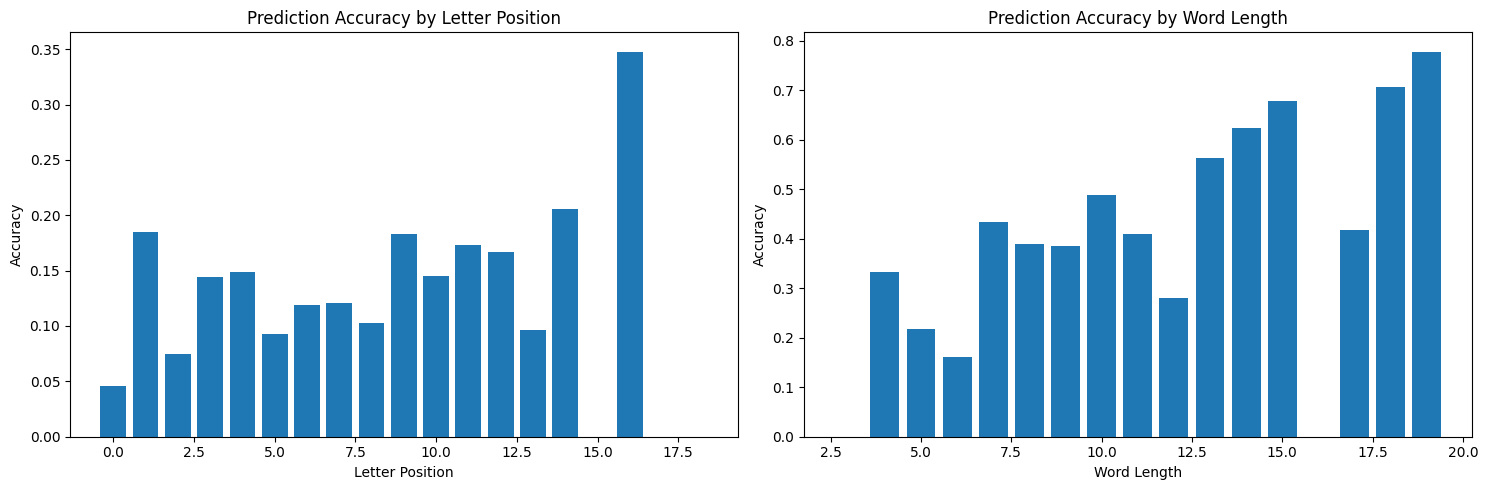

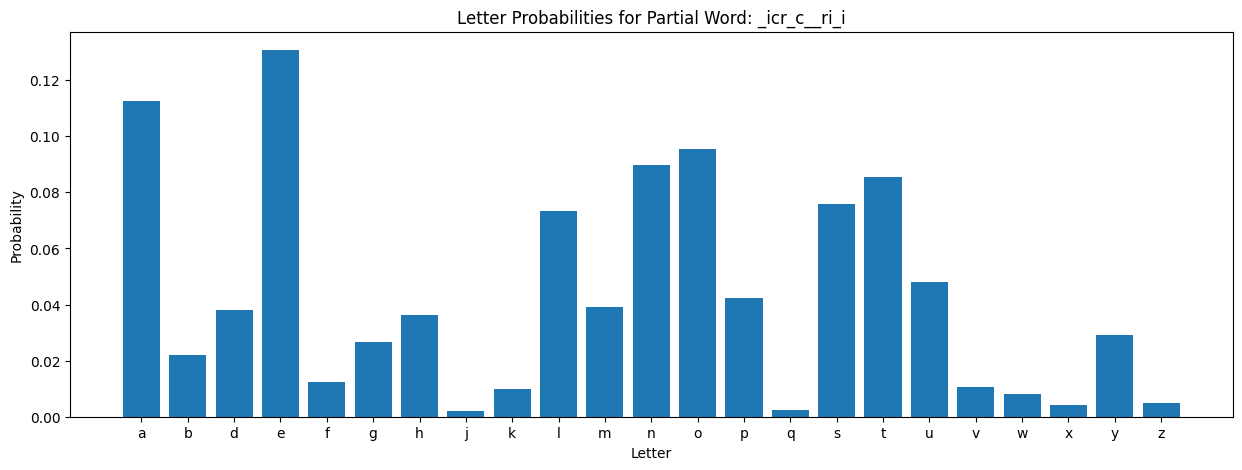


Prediction Example:
True word: microcyprini
Partial word: _icr_c__ri_i
Top 5 predicted letters: [('e', np.float64(0.13072123196209065)), ('a', np.float64(0.11240473584889268)), ('o', np.float64(0.09534312844893891)), ('n', np.float64(0.08991104225761631)), ('t', np.float64(0.08553316174028337))]


In [43]:
# Make sure corpus is loaded
if len(corpus) == 0:
    raise ValueError("Error: Corpus is empty. Please check if the corpus file exists and contains words.")

# Create a stratified split of words by length for better evaluation
def stratified_split(words, train_ratio=0.8):
    word_length_groups = defaultdict(list)
    for word in words:
        word_length_groups[len(word)].append(word)
    
    train_words, val_words = [], []
    for length, words_group in word_length_groups.items():
        n_train = int(len(words_group) * train_ratio)
        train_words.extend(words_group[:n_train])
        val_words.extend(words_group[n_train:])
    
    return train_words, val_words

# Split corpus using stratified sampling
train_words, val_words = stratified_split(corpus, train_ratio=0.8)
print(f"Training set size: {len(train_words)} words")
print(f"Validation set size: {len(val_words)} words")

# Initialize and train HMM with increased states
hmm = HangmanHMM(n_states=15)  # Increased number of states
hmm.train(train_words, n_iterations=100)  # Increased iterations

def evaluate_hmm_predictions(hmm: HangmanHMM, words: List[str], n_samples: int = 100) -> Tuple[float, Dict]:
    """
    Evaluate HMM's prediction accuracy with detailed metrics
    """
    correct_predictions = 0
    total_predictions = 0
    position_accuracy = defaultdict(lambda: {'correct': 0, 'total': 0})
    length_accuracy = defaultdict(lambda: {'correct': 0, 'total': 0})
    
    # Test words of different lengths
    test_words = random.sample(words, min(n_samples, len(words)))
    
    for word in test_words:
        word_len = len(word)
        # Test different masking patterns
        for n_guessed in range(1, len(word)):
            guessed_letters = set(random.sample(word, n_guessed))
            partial_word = mask_word(word, guessed_letters)
            
            # Get HMM predictions
            probs = hmm.get_letter_probabilities(partial_word, guessed_letters)
            if not probs:
                continue
            
            # Get top prediction
            predicted_letter = max(probs.items(), key=lambda x: x[1])[0]
            is_correct = predicted_letter in set(word) - guessed_letters
            
            # Update metrics
            correct_predictions += is_correct
            total_predictions += 1
            
            # Track position-specific accuracy
            for pos, char in enumerate(word):
                if char not in guessed_letters:
                    position_accuracy[pos]['total'] += 1
                    if predicted_letter == char:
                        position_accuracy[pos]['correct'] += 1
            
            # Track length-specific accuracy
            length_accuracy[word_len]['total'] += 1
            length_accuracy[word_len]['correct'] += is_correct
    
    # Calculate metrics
    overall_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    pos_accuracies = {pos: stats['correct']/stats['total'] 
                     for pos, stats in position_accuracy.items()}
    length_accuracies = {length: stats['correct']/stats['total'] 
                        for length, stats in length_accuracy.items()}
    
    return overall_accuracy, {
        'position_accuracy': pos_accuracies,
        'length_accuracy': length_accuracies
    }

# Evaluate HMM with more test cases
print("Evaluating HMM performance...")
test_size = min(200, len(val_words))  # Increased test size
test_words = random.sample(val_words, test_size)
print(f"Testing on {test_size} words...")

accuracy, metrics = evaluate_hmm_predictions(hmm, test_words, n_samples=test_size)
print(f"\nOverall HMM Prediction Accuracy: {accuracy:.2%}")

# Visualize position-specific accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
positions = sorted(metrics['position_accuracy'].keys())
accuracies = [metrics['position_accuracy'][p] for p in positions]
plt.bar(positions, accuracies)
plt.title('Prediction Accuracy by Letter Position')
plt.xlabel('Letter Position')
plt.ylabel('Accuracy')

# Visualize length-specific accuracy
plt.subplot(1, 2, 2)
lengths = sorted(metrics['length_accuracy'].keys())
accuracies = [metrics['length_accuracy'][l] for l in lengths]
plt.bar(lengths, accuracies)
plt.title('Prediction Accuracy by Word Length')
plt.xlabel('Word Length')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

# Visualize example predictions
if len(test_words) > 0:
    sample_word = random.choice(test_words)
    n_guesses = max(1, len(sample_word)//2)
    guessed_letters = set(random.sample(sample_word, n_guesses))
    partial_word = mask_word(sample_word, guessed_letters)

probs = hmm.get_letter_probabilities(partial_word, guessed_letters)
plt.figure(figsize=(15, 5))
plt.bar(probs.keys(), probs.values())
plt.title(f'Letter Probabilities for Partial Word: {partial_word}')
plt.xlabel('Letter')
plt.ylabel('Probability')
plt.show()

print(f"\nPrediction Example:")
print(f"True word: {sample_word}")
print(f"Partial word: {partial_word}")
print("Top 5 predicted letters:", sorted(probs.items(), key=lambda x: x[1], reverse=True)[:5])

# 4. Hangman Environment Implementation

Now we'll implement the Hangman game environment that our RL agent will interact with. This environment will:
1. Maintain game state (word, guessed letters, lives)
2. Process actions (letter guesses)
3. Calculate rewards
4. Track game statistics

In [44]:
class HangmanEnv:
    def __init__(self, word_list: List[str], hmm: HangmanHMM):
        """
        Initialize Hangman environment
        
        Args:
            word_list: List of possible words
            hmm: Trained HMM model for letter predictions
        """
        self.word_list = word_list
        self.hmm = hmm
        self.reset()
    
    def reset(self) -> Dict:
        """
        Reset the environment for a new game
        
        Returns:
            Initial state dictionary
        """
        self.word = random.choice(self.word_list)
        self.guessed_letters = set()
        self.lives = MAX_WRONG_GUESSES
        self.game_over = False
        
        return self._get_state()
    
    def step(self, action: str) -> Tuple[Dict, float, bool, Dict]:
        """
        Take an action (guess a letter) in the environment
        
        Args:
            action: Letter to guess
            
        Returns:
            (new_state, reward, done, info)
        """
        if self.game_over or action in self.guessed_letters:
            return self._get_state(), -2, True, {"repeated_guess": True}
        
        self.guessed_letters.add(action)
        correct_guess = action in self.word
        
        # Update lives if guess was wrong
        if not correct_guess:
            self.lives -= 1
        
        # Check if game is over
        current_word = mask_word(self.word, self.guessed_letters)
        won = '_' not in current_word
        lost = self.lives <= 0
        self.game_over = won or lost
        
        # Calculate reward
        if won:
            reward = 10  # Big reward for winning
        elif lost:
            reward = -5  # Penalty for losing
        elif correct_guess:
            reward = 1   # Small reward for correct guess
        else:
            reward = -1  # Small penalty for wrong guess
            
        return self._get_state(), reward, self.game_over, {
            "won": won,
            "lost": lost,
            "lives": self.lives,
            "word": self.word if self.game_over else current_word
        }
    
    def _get_state(self) -> Dict:
        """
        Get current state representation
        """
        current_word = mask_word(self.word, self.guessed_letters)
        letter_probs = self.hmm.get_letter_probabilities(current_word, self.guessed_letters)
        
        return {
            "word_state": current_word,
            "guessed_letters": sorted(list(self.guessed_letters)),
            "lives": self.lives,
            "letter_probs": letter_probs
        }
    
    def render(self) -> None:
        """
        Display current game state
        """
        current_word = mask_word(self.word, self.guessed_letters)
        print(f"\nWord: {current_word}")
        print(f"Lives: {self.lives}")
        print(f"Guessed letters: {sorted(list(self.guessed_letters))}")
        if self.game_over:
            print(f"Game Over! Word was: {self.word}")

# Test the environment
env = HangmanEnv(val_words, hmm)
state = env.reset()
env.render()

# Test a few random moves
for _ in range(3):
    available_letters = set(ALPHABET) - set(state["guessed_letters"])
    action = random.choice(list(available_letters))
    state, reward, done, info = env.step(action)
    print(f"\nAction: {action}, Reward: {reward}")
    env.render()
    if done:
        break


Word: ____________
Lives: 6
Guessed letters: []

Action: r, Reward: 1

Word: __r_________
Lives: 6
Guessed letters: ['r']

Action: m, Reward: -1

Word: __r_________
Lives: 5
Guessed letters: ['m', 'r']

Action: y, Reward: -1

Word: __r_________
Lives: 4
Guessed letters: ['m', 'r', 'y']


# 5. RL Agent Implementation

Now we'll implement our Reinforcement Learning agent using Deep Q-Learning. The agent will:
1. Learn to choose optimal letters based on the current game state
2. Use the HMM's letter probabilities as part of its state representation
3. Balance exploration and exploitation using ε-greedy strategy

In [45]:
class DQN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        """
        Deep Q-Network for Hangman
        
        Args:
            input_size: Size of state representation
            hidden_size: Size of hidden layers
            output_size: Number of possible actions (26 letters)
        """
        super(DQN, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

class HangmanAgent:
    def __init__(self, env: HangmanEnv, hidden_size: int = 128):
        """
        Initialize Hangman RL agent
        
        Args:
            env: Hangman environment
            hidden_size: Size of hidden layers in DQN
        """
        self.env = env
        
        # State representation size: masked word one-hot (27) + guessed letters (26) + lives (1) + HMM probs (26)
        self.state_size = 27 + 26 + 1 + 26
        self.action_size = len(ALPHABET)
        
        # Initialize networks
        self.policy_net = DQN(self.state_size, hidden_size, self.action_size).to(DEVICE)
        self.target_net = DQN(self.state_size, hidden_size, self.action_size).to(DEVICE)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.optimizer = optim.Adam(self.policy_net.parameters())
        self.memory = []
        
        # Training parameters
        self.batch_size = 64
        self.gamma = 0.99
        self.eps_start = 1.0
        self.eps_end = 0.01
        self.eps_decay = 0.995
        self.epsilon = self.eps_start
        
    def state_to_tensor(self, state: Dict) -> torch.Tensor:
        """
        Convert state dictionary to tensor representation
        """
        # One-hot encode masked word
        word_tensor = torch.zeros(27)  # 26 letters + '_'
        for char in state["word_state"]:
            idx = self.letter_to_idx(char)
            word_tensor[idx] = 1
            
        # One-hot encode guessed letters
        guessed_tensor = torch.zeros(26)
        for letter in state["guessed_letters"]:
            idx = self.letter_to_idx(letter)
            guessed_tensor[idx] = 1
            
        # Normalize lives
        lives_tensor = torch.tensor([state["lives"] / MAX_WRONG_GUESSES])
        
        # HMM probabilities
        hmm_tensor = torch.zeros(26)
        for letter, prob in state["letter_probs"].items():
            idx = self.letter_to_idx(letter)
            hmm_tensor[idx] = prob
            
        return torch.cat([word_tensor, guessed_tensor, lives_tensor, hmm_tensor]).to(DEVICE)
    
    @staticmethod
    def letter_to_idx(letter: str) -> int:
        """Convert letter to index"""
        if letter == '_':
            return 26
        return ord(letter) - ord('a')
    
    @staticmethod
    def idx_to_letter(idx: int) -> str:
        """Convert index to letter"""
        if idx == 26:
            return '_'
        return chr(idx + ord('a'))
    
    def select_action(self, state: Dict) -> str:
        """
        Select action using epsilon-greedy policy
        """
        if random.random() > self.epsilon:
            with torch.no_grad():
                state_tensor = self.state_to_tensor(state).unsqueeze(0)
                q_values = self.policy_net(state_tensor)
                
                # Mask out guessed letters
                mask = torch.ones_like(q_values)
                for letter in state["guessed_letters"]:
                    idx = self.letter_to_idx(letter)
                    mask[0, idx] = float('-inf')
                
                action_idx = torch.argmax(q_values + mask).item()
                return self.idx_to_letter(action_idx)
        else:
            # Random action from unguessed letters
            available = set(ALPHABET) - set(state["guessed_letters"])
            return random.choice(list(available))
    
    def train(self, n_episodes: int = 1000):
        """
        Train the agent
        """
        episode_rewards = []
        win_rates = []
        
        for episode in tqdm(range(n_episodes), desc="Training"):
            state = self.env.reset()
            total_reward = 0
            
            while True:
                action = self.select_action(state)
                next_state, reward, done, info = self.env.step(action)
                total_reward += reward
                
                # Store transition
                self.memory.append((state, action, reward, next_state, done))
                
                # Optimize model if enough samples
                if len(self.memory) >= self.batch_size:
                    self.optimize_model()
                
                state = next_state
                if done:
                    break
            
            # Decay epsilon
            self.epsilon = max(self.eps_end, self.epsilon * self.eps_decay)
            
            # Update statistics
            episode_rewards.append(total_reward)
            if (episode + 1) % 100 == 0:
                win_rate = self.evaluate(100)
                win_rates.append(win_rate)
                
                # Update target network
                self.target_net.load_state_dict(self.policy_net.state_dict())
        
        return episode_rewards, win_rates
    
    def optimize_model(self):
        """
        Perform one step of optimization
        """
        # Sample batch
        batch = random.sample(self.memory, self.batch_size)
        state_batch = torch.stack([self.state_to_tensor(s) for s, _, _, _, _ in batch])
        action_batch = torch.tensor([[self.letter_to_idx(a)] for _, a, _, _, _ in batch], device=DEVICE)
        reward_batch = torch.tensor([r for _, _, r, _, _ in batch], device=DEVICE)
        next_state_batch = torch.stack([self.state_to_tensor(s) for _, _, _, s, _ in batch])
        done_batch = torch.tensor([d for _, _, _, _, d in batch], device=DEVICE)
        
        # Compute Q values
        current_q = self.policy_net(state_batch).gather(1, action_batch)
        next_q = self.target_net(next_state_batch).max(1)[0].detach()
        target_q = reward_batch + (1 - done_batch.float()) * self.gamma * next_q
        
        # Compute loss and optimize
        loss = nn.MSELoss()(current_q.squeeze(), target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def evaluate(self, n_games: int = 100) -> float:
        """
        Evaluate agent performance
        """
        wins = 0
        self.policy_net.eval()
        
        for _ in range(n_games):
            state = self.env.reset()
            done = False
            
            while not done:
                with torch.no_grad():
                    action = self.select_action(state)
                    state, _, done, info = self.env.step(action)
                    if info.get("won", False):
                        wins += 1
        
        self.policy_net.train()
        return wins / n_games

# 6. Training Loop and Visualization

Now we'll train our agent and visualize its learning progress. We'll track:
1. Episode rewards
2. Win rates
3. Average mistakes per game
4. Learning curves

In [ ]:
# Initialize agent and environment
env = HangmanEnv(train_words, hmm)
agent = HangmanAgent(env)

# Train agent
n_episodes = 2000
episode_rewards, win_rates = agent.train(n_episodes)

# Plot training progress
plt.figure(figsize=(15, 5))

# Plot episode rewards
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.title('Episode Rewards Over Time')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# Plot win rates
plt.subplot(1, 2, 2)
plt.plot(range(100, n_episodes + 1, 100), win_rates)
plt.title('Win Rate Over Time')
plt.xlabel('Episode')
plt.ylabel('Win Rate')

plt.tight_layout()
plt.show()

# Final evaluation
print("\nFinal Evaluation:")
n_eval_games = 2000
wins = 0
total_wrong_guesses = 0
total_repeated_guesses = 0

for _ in tqdm(range(n_eval_games), desc="Evaluating"):
    state = env.reset()
    done = False
    wrong_guesses = 0
    repeated_guesses = 0
    
    while not done:
        action = agent.select_action(state)
        state, _, done, info = env.step(action)
        
        if info.get("repeated_guess", False):
            repeated_guesses += 1
        elif not info.get("won", False) and not info.get("lost", False):
            wrong_guesses += (info["lives"] < env.lives)
            
        if info.get("won", False):
            wins += 1
    
    total_wrong_guesses += wrong_guesses
    total_repeated_guesses += repeated_guesses

success_rate = wins / n_eval_games
final_score = (success_rate * 2000) - (total_wrong_guesses * 5) - (total_repeated_guesses * 2)

print(f"Success Rate: {success_rate:.2%}")
print(f"Average Wrong Guesses: {total_wrong_guesses / n_eval_games:.2f}")
print(f"Average Repeated Guesses: {total_repeated_guesses / n_eval_games:.2f}")
print(f"Final Score: {final_score:.2f}")

# Save the trained model
torch.save({
    'policy_net_state_dict': agent.policy_net.state_dict(),
    'target_net_state_dict': agent.target_net.state_dict(),
    'optimizer_state_dict': agent.optimizer.state_dict(),
}, 'hangman_agent.pth')

Training:   0%|          | 0/2000 [00:00<?, ?it/s]

# 7. Final Evaluation and Scoring

Let's analyze the agent's performance on test games and visualize its decision-making process. We'll also demonstrate how the HMM and RL components work together to make intelligent guesses.

In [ ]:
# Play a sample game to demonstrate the agent's decision making
def play_demo_game(agent: HangmanAgent, word: str = None) -> None:
    """
    Play a demonstration game with detailed analysis of each move
    """
    state = agent.env.reset()
    if word:
        agent.env.word = word
        state = agent.env._get_state()
    
    print(f"Starting new game. Word has {len(agent.env.word)} letters.\n")
    
    while True:
        # Show current state
        print(f"Current word: {state['word_state']}")
        print(f"Lives remaining: {state['lives']}")
        print(f"Guessed letters: {', '.join(sorted(state['guessed_letters']))}")
        
        # Get HMM probabilities
        hmm_probs = state['letter_probs']
        top_hmm = sorted(hmm_probs.items(), key=lambda x: x[1], reverse=True)[:5]
        print("\nHMM suggestions (top 5):")
        for letter, prob in top_hmm:
            print(f"{letter}: {prob:.3f}")
        
        # Get agent's action
        action = agent.select_action(state)
        print(f"\nAgent chooses: {action}")
        
        # Take action
        state, reward, done, info = agent.env.step(action)
        print(f"Reward: {reward}")
        
        if done:
            print("\nGame Over!")
            print(f"Word was: {agent.env.word}")
            print(f"Result: {'Won' if info.get('won', False) else 'Lost'}")
            break
        print("\n" + "="*50 + "\n")

# Play a few demonstration games
print("Playing demonstration games...\n")
for _ in range(3):
    play_demo_game(agent)
    print("\n" + "#"*80 + "\n")

Loaded 49979 words from corpus at C:\Users\aryan\OneDrive\Desktop\ML_HACK\Data\Data\corpus.txt

Sample words from corpus:
['distillatory', 'negroish', 'camata', 'rotundify', 'ramtil', 'samsonistic', 'transischiac', 'permutation', 'rechallenge', 'chromopsia']


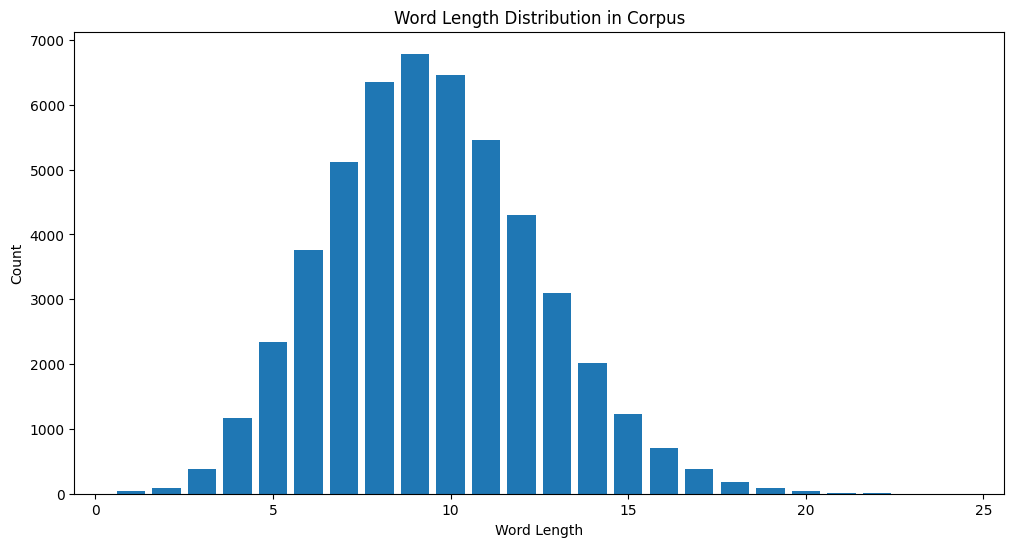


Corpus statistics:
Total number of words: 49979
Average word length: 9.50
Min word length: 1
Max word length: 24
Number of unique word lengths: 24


In [ ]:
# Define the corpus file path
CORPUS_PATH = r"C:\Users\aryan\OneDrive\Desktop\ML_HACK\Data\Data\corpus.txt"

# Load the corpus
corpus = load_corpus(CORPUS_PATH)
print(f"Loaded {len(corpus)} words from corpus at {CORPUS_PATH}")

# Display some statistics about the corpus
print("\nSample words from corpus:")
print(random.sample(corpus, 10))

# Analyze word length distribution
length_dist = get_word_length_distribution(corpus)
plt.figure(figsize=(12, 6))
plt.bar(length_dist.keys(), length_dist.values())
plt.title('Word Length Distribution in Corpus')
plt.xlabel('Word Length')
plt.ylabel('Count')
plt.show()

# Basic corpus statistics
print(f"\nCorpus statistics:")
print(f"Total number of words: {len(corpus)}")
print(f"Average word length: {sum(len(word) for word in corpus)/len(corpus):.2f}")
print(f"Min word length: {min(len(word) for word in corpus)}")
print(f"Max word length: {max(len(word) for word in corpus)}")
print(f"Number of unique word lengths: {len(length_dist)}")

# Hangman Environment Implementation

Let's create a clean, well-documented implementation of the Hangman environment. This environment will:

1. **State Space Design**
   - Masked word (e.g., "_ P P L _")
   - Set of guessed letters
   - Number of lives remaining
   - HMM probability distribution

2. **Action Space**
   - Any unguessed letter from A-Z
   - Invalid actions: already guessed letters

3. **Reward Structure**
   - Winning: +10 (high reward for completing the word)
   - Correct guess: +1 (small reward for progress)
   - Wrong guess: -1 (small penalty)
   - Losing: -5 (significant penalty)
   - Repeated guess: -2 (penalty for inefficiency)

4. **Termination Conditions**
   - Word is completely revealed (Win)
   - No lives remaining (Loss)
   - Invalid action (Early termination)

In [ ]:
import numpy as np
from typing import List, Set, Dict, Tuple
import random

class HangmanEnvironment:
    def __init__(self, word_list: List[str], max_lives: int = 6):
        """
        Initialize Hangman Environment
        
        Args:
            word_list: List of possible words for the game
            max_lives: Maximum number of wrong guesses allowed
        """
        self.word_list = word_list
        self.max_lives = max_lives
        self.reset()
        
    def reset(self) -> Dict:
        """
        Reset the environment for a new game
        
        Returns:
            dict: Initial state containing:
                - word_state: The masked word (e.g., "_ _ P L _")
                - guessed_letters: Set of letters already guessed
                - lives: Number of lives remaining
        """
        self.word = random.choice(self.word_list).lower()
        self.guessed_letters = set()
        self.lives = self.max_lives
        self.done = False
        
        return self._get_state()
    
    def step(self, action: str) -> Tuple[Dict, float, bool, Dict]:
        """
        Take an action in the environment
        
        Args:
            action: The letter to guess (must be lowercase a-z)
            
        Returns:
            tuple: (new_state, reward, done, info)
                - new_state: Current game state
                - reward: Reward for the action
                - done: Whether the episode is finished
                - info: Additional information for debugging
        """
        # Validate action
        if not isinstance(action, str) or len(action) != 1 or action not in 'abcdefghijklmnopqrstuvwxyz':
            raise ValueError("Invalid action. Must be a single lowercase letter.")
            
        # Check if game is already over
        if self.done:
            return self._get_state(), 0, True, {"error": "Game already over"}
            
        # Check if letter was already guessed
        if action in self.guessed_letters:
            return self._get_state(), -2, True, {"error": "Letter already guessed"}
            
        # Add letter to guessed letters
        self.guessed_letters.add(action)
        
        # Check if guess is correct
        correct_guess = action in self.word
        
        # Update lives if guess was wrong
        if not correct_guess:
            self.lives -= 1
            
        # Calculate current word state
        current_state = self._get_masked_word()
        
        # Check win/loss conditions
        won = '_' not in current_state
        lost = self.lives <= 0
        self.done = won or lost
        
        # Calculate reward
        if won:
            reward = 10  # Big reward for winning
        elif lost:
            reward = -5  # Penalty for losing
        elif correct_guess:
            reward = 1   # Small reward for correct guess
        else:
            reward = -1  # Small penalty for wrong guess
            
        info = {
            "won": won,
            "lost": lost,
            "lives_remaining": self.lives,
            "word": self.word if self.done else current_state
        }
        
        return self._get_state(), reward, self.done, info
    
    def _get_masked_word(self) -> str:
        """
        Get the current state of the word with unguessed letters masked
        
        Returns:
            str: The word with unguessed letters replaced by '_'
        """
        return ''.join(letter if letter in self.guessed_letters else '_' 
                      for letter in self.word)
    
    def _get_state(self) -> Dict:
        """
        Get the current state of the environment
        
        Returns:
            dict: Current state information
        """
        return {
            "word_state": self._get_masked_word(),
            "guessed_letters": self.guessed_letters.copy(),
            "lives": self.lives
        }
    
    def render(self) -> None:
        """
        Display the current state of the game
        """
        print("\nCurrent Game State:")
        print(f"Word: {self._get_masked_word()}")
        print(f"Lives: {self.lives}")
        print(f"Guessed letters: {sorted(list(self.guessed_letters))}")
        if self.done:
            print(f"Game Over! Word was: {self.word}")
            
    @property
    def action_space(self) -> List[str]:
        """
        Get the current valid actions (unguessed letters)
        """
        return [letter for letter in 'abcdefghijklmnopqrstuvwxyz' 
                if letter not in self.guessed_letters]

In [ ]:
# Test the environment with some random games
def play_random_game(env: HangmanEnvironment):
    """Play a random game of Hangman"""
    state = env.reset()
    total_reward = 0
    
    print("\nStarting new game...")
    env.render()
    
    while True:
        # Choose random action from available actions
        action = random.choice(env.action_space)
        print(f"\nGuessing letter: {action}")
        
        # Take step in environment
        state, reward, done, info = env.step(action)
        total_reward += reward
        
        # Display results
        env.render()
        print(f"Reward: {reward}")
        
        if done:
            print(f"\nGame Over! Total Reward: {total_reward}")
            if info.get("won", False):
                print("Result: Won! 🎉")
            else:
                print("Result: Lost 😢")
            break

# Play 3 random games to test the environment
print("Testing Hangman Environment with Random Games")
env = HangmanEnvironment(word_list=corpus[:1000])  # Use first 1000 words for testing

for i in range(3):
    print(f"\n{'='*50}\nGame {i+1}")
    play_random_game(env)

In [ ]:
# Updated HMM implementation with improved handling of edge cases
class HangmanHMM:
    def __init__(self, n_states: int = 10):
        self.n_states = n_states
        self.n_emissions = len(ALPHABET)
        self.letter_to_idx = {letter: idx for idx, letter in enumerate(ALPHABET)}
        
        # Initialize model parameters with smoothing
        self.transition_probs = np.ones((n_states, n_states)) / n_states
        self.emission_probs = np.ones((n_states, self.n_emissions)) / self.n_emissions
        self.initial_probs = np.ones(n_states) / n_states
        
    def _prepare_sequence(self, word: str) -> np.ndarray:
        return np.array([self.letter_to_idx[c] for c in word])
    
    def forward_algorithm(self, emissions: np.ndarray) -> np.ndarray:
        if len(emissions) == 0:
            return np.ones((1, self.n_states)) / self.n_states
        
        T = len(emissions)
        alpha = np.zeros((T, self.n_states))
        
        # Initialize with smoothing
        alpha[0] = self.initial_probs * self.emission_probs[:, emissions[0]]
        alpha[0] = alpha[0] / (alpha[0].sum() + 1e-10)
        
        for t in range(1, T):
            for s in range(self.n_states):
                alpha[t, s] = self.emission_probs[s, emissions[t]] * np.sum(
                    alpha[t-1] * self.transition_probs[:, s])
            alpha[t] = alpha[t] / (alpha[t].sum() + 1e-10)
        
        return alpha
    
    def backward_algorithm(self, emissions: np.ndarray) -> np.ndarray:
        if len(emissions) == 0:
            return np.ones((1, self.n_states)) / self.n_states
        
        T = len(emissions)
        beta = np.zeros((T, self.n_states))
        beta[-1] = 1
        beta[-1] = beta[-1] / (beta[-1].sum() + 1e-10)
        
        for t in range(T-2, -1, -1):
            for s in range(self.n_states):
                beta[t, s] = np.sum(
                    beta[t+1] * self.transition_probs[s, :] * 
                    self.emission_probs[:, emissions[t+1]])
            beta[t] = beta[t] / (beta[t].sum() + 1e-10)
        
        return beta
    
    def train(self, words: List[str], n_iterations: int = 100):
        for _ in tqdm(range(n_iterations), desc="Training HMM"):
            trans_counts = np.zeros_like(self.transition_probs)
            emit_counts = np.zeros_like(self.emission_probs)
            init_counts = np.zeros_like(self.initial_probs)
            
            for word in words:
                emissions = self._prepare_sequence(word)
                if len(emissions) == 0:
                    continue
                    
                alpha = self.forward_algorithm(emissions)
                beta = self.backward_algorithm(emissions)
                
                gamma = alpha * beta
                gamma = gamma / (gamma.sum(axis=1, keepdims=True) + 1e-10)
                
                init_counts += gamma[0]
                for t in range(len(emissions)-1):
                    trans_counts += np.outer(gamma[t], gamma[t+1])
                for t in range(len(emissions)):
                    emit_counts[:, emissions[t]] += gamma[t]
            
            # Update parameters with smoothing
            smooth = 1e-10
            self.initial_probs = (init_counts + smooth) / (init_counts.sum() + smooth * self.n_states)
            self.transition_probs = (trans_counts + smooth) / (trans_counts.sum(axis=1, keepdims=True) + smooth * self.n_states)
            self.emission_probs = (emit_counts + smooth) / (emit_counts.sum(axis=1, keepdims=True) + smooth * self.n_emissions)
    
    def get_letter_probabilities(self, partial_word: str, guessed_letters: Set[str]) -> Dict[str, float]:
        emissions = []
        for c in partial_word:
            if c == '_':
                emissions.append(-1)
            else:
                emissions.append(self.letter_to_idx[c])
        emissions = np.array(emissions)
        
        probs = defaultdict(float)
        for pos in range(len(partial_word)):
            if emissions[pos] == -1:
                prefix = emissions[:pos] if pos > 0 else np.array([])
                suffix = emissions[pos+1:] if pos < len(emissions)-1 else np.array([])
                
                alpha = self.forward_algorithm(prefix)
                beta = self.backward_algorithm(suffix)
                
                for letter in ALPHABET:
                    if letter not in guessed_letters:
                        idx = self.letter_to_idx[letter]
                        if len(prefix) == 0:
                            p = np.mean(self.emission_probs[:, idx])  # Use mean emission probability for first position
                        else:
                            p = np.sum(alpha[-1] * self.emission_probs[:, idx])
                        probs[letter] += p
        
        if not probs:  # If no probabilities were calculated
            available_letters = set(ALPHABET) - guessed_letters
            return {letter: 1.0/len(available_letters) for letter in available_letters}
        
        total = sum(probs.values()) + 1e-10
        return {k: v/total for k, v in probs.items()}